**Horizontal integration (Simulation)**

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import copy
import scipy
import anndata as ad

from SpaMode.preprocess import clr_normalize_each_cell, pca, lsi
from SpaMode.preprocess import construct_neighbor_graph
from SpaMode.Process_BC_list import data_preprocessing, combine_BC, process_spatial_adj, get_feat_adj
from SpaMode.utils import clustering, peak_sets_alignment, gene_sets_alignment
from cal_matrics import eval
from scipy.sparse import coo_matrix
from sklearn.neighbors import kneighbors_graph
from scipy.sparse import csr_matrix
from scipy.sparse import issparse


# Fix random seed
from SME.preprocess import fix_seed
random_seed = 2024
fix_seed(random_seed)

*Process batch data*

In [2]:
base_path = '/home/hxl/Spa_Multi-omics/Gen_sim/multiome_ZINB_NB_sim_BC/'

file_paths = {
    '1': [base_path + '/Slice-1/RNA.h5ad',
          base_path + '/Slice-1/Protein.h5ad'],
    '2': [base_path + '/Slice-2/RNA.h5ad',
          base_path + '/Slice-2/Protein.h5ad'],
    '3': [base_path + '/Slice-3/RNA.h5ad',
          base_path + '/Slice-3/Protein.h5ad'],
}
# Load all AnnData objects
adata_omics1_list = []
adata_omics2_list = []
for paths in file_paths.values():
    adata_omics1, adata_omics2 = [sc.read_h5ad(fp) for fp in paths]
    adata_omics1_list.append(adata_omics1)
    adata_omics2_list.append(adata_omics2)
# Align gene and peak sets
# adata_omics1_list = gene_sets_alignment(adata_omics1_list)
# adata_omics2_list = peak_sets_alignment(adata_omics2_list)
adata_omics1_norm_list = []
adata_omics2_norm_list = []
for adata1, adata2 in zip(adata_omics1_list, adata_omics2_list):
    # Create copies for source data
    adata_omics1_src = copy.deepcopy(adata1)
    adata_omics2_src = copy.deepcopy(adata2)
    # Create copies for normalized data and preprocess
    adata_omics1_norm, adata_omics2_norm = data_preprocessing(copy.deepcopy(adata1), copy.deepcopy(adata2))
    adata_omics1_norm_list.append(adata_omics1_norm)
    adata_omics2_norm_list.append(adata_omics2_norm)

# Combine across batches
src_adata_omics1 = combine_BC(adata_omics1_list)
src_adata_omics2 = combine_BC(adata_omics2_list)
src_adata_omics1_BC, src_adata_omics2_BC = data_preprocessing(src_adata_omics1, src_adata_omics2)

# Construct neighbor graphs for each slice
adata_list = [
    construct_neighbor_graph(norm_adata1, norm_adata2, datatype='Sim_L')
    for norm_adata1, norm_adata2 in zip(adata_omics1_norm_list, adata_omics2_norm_list)
]
spatial_adj_pd = process_spatial_adj(adata_list)

# Construct neighbor graph for combined data
adata = construct_neighbor_graph(src_adata_omics1_BC, src_adata_omics2_BC, datatype='Sim_L')
adata['adata_omics1'].uns['adj_spatial'] = spatial_adj_pd
adata['adata_omics2'].uns['adj_spatial'] = spatial_adj_pd

# Initialize norm_feat in the combined adata
total_obs = src_adata_omics1_BC.n_obs
adata['adata_omics1'].obsm['norm_feat'] = np.zeros((total_obs, adata_omics1_norm_list[0].obsm['feat'].shape[1]))
adata['adata_omics2'].obsm['norm_feat'] = np.zeros((total_obs, adata_omics2_norm_list[0].obsm['feat'].shape[1]))

# Fill norm_feat with normalized features from each slice
start_idx = 0
for norm_adata1 in adata_omics1_norm_list:
    end_idx = start_idx + norm_adata1.n_obs
    adata['adata_omics1'].obsm['norm_feat'][start_idx:end_idx] = norm_adata1.obsm['feat']
    start_idx = end_idx
start_idx = 0
for norm_adata2 in adata_omics2_norm_list:
    end_idx = start_idx + norm_adata2.n_obs
    adata['adata_omics2'].obsm['norm_feat'][start_idx:end_idx] = norm_adata2.obsm['feat']
    start_idx = end_idx

adata_omics1_adj_feature_Sparse = get_feat_adj(adata_omics1_norm_list)
adata_omics2_adj_feature_Sparse = get_feat_adj(adata_omics2_norm_list)

adata['adata_omics1'].obsm['norm_adj_feature'] = adata_omics1_adj_feature_Sparse
adata['adata_omics2'].obsm['norm_adj_feature'] = adata_omics2_adj_feature_Sparse

# Save processed BC data
adata['adata_omics1'].write_h5ad('./Data/Sim_BC/{}.h5ad'.format('adata_RNA_BE_pca'))
adata['adata_omics2'].write_h5ad('./Data/Sim_BC/{}.h5ad'.format('adata_Protein_BE_pca'))

/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 1296 × 600
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'modality', 'hvg', 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac', 'feat'
    varm: 'nsload', 'spload'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1296 × 350
    var: 'mean', 'std'
    uns: 'modality', 'units'
    obsm: 'nsfac', 'spatial', 'spfac', 'feat'
    varm: 'nsload', 'spload'
    layers: 'counts'


/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 1296 × 600
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'modality', 'hvg', 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac', 'feat'
    varm: 'nsload', 'spload'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1296 × 350
    var: 'mean', 'std'
    uns: 'modality', 'units'
    obsm: 'nsfac', 'spatial', 'spfac', 'feat'
    varm: 'nsload', 'spload'
    layers: 'counts'


/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 1296 × 600
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'modality', 'hvg', 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac', 'feat'
    varm: 'nsload', 'spload'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1296 × 350
    var: 'mean', 'std'
    uns: 'modality', 'units'
    obsm: 'nsfac', 'spatial', 'spfac', 'feat'
    varm: 'nsload', 'spload'
    layers: 'counts'
(1296, 600)
(1296, 600)
(1296, 600)
(1296, 350)
(1296, 350)
(1296, 350)


/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 3888 × 600
    obs: 'Batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial', 'feat'
AnnData object with n_obs × n_vars = 3888 × 350
    obs: 'Batch'
    var: 'mean', 'std'
    obsm: 'spatial', 'feat'
Spatial_neighbors = 4
Feature_neighbors = 20
Spatial_neighbors = 4
Feature_neighbors = 20
Spatial_neighbors = 4
Feature_neighbors = 20
Spatial_neighbors = 4
Feature_neighbors = 20


*Training Config*

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

file_paths = {
        '1': ['/Slice-1/RNA.h5ad',
              '/Slice-1/Protein.h5ad',
              '/Slice-1/ATAC.h5ad'],
        '2': ['/Slice-2/RNA.h5ad',
              '/Slice-2/Protein.h5ad',
              '/Slice-2/ATAC.h5ad'],
        '3': ['/Slice-3/RNA.h5ad',
              '/Slice-3/Protein.h5ad',
              '/Slice-3/ATAC.h5ad'],
    }

adata_omics1 = sc.read_h5ad('/home/hxl/Spa_Multi-omics/0222/Data/Sim_0611/adata_RNA_BE_pca.h5ad')
adata_omics2 = sc.read_h5ad('/home/hxl/Spa_Multi-omics/0222/Data/Sim_0611/adata_Protein_BE_pca.h5ad')

print(adata_omics1)
print(adata_omics2)
adata = {
    'adata_omics1': adata_omics1,
    'adata_omics2': adata_omics2,
}

AnnData object with n_obs × n_vars = 3888 × 600
    obs: 'Batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'adj_spatial', 'hvg', 'log1p'
    obsm: 'adj_feature', 'feat', 'norm_adj_feature', 'norm_feat', 'spatial'
AnnData object with n_obs × n_vars = 3888 × 350
    obs: 'Batch'
    var: 'mean', 'std'
    uns: 'adj_spatial'
    obsm: 'adj_feature', 'feat', 'norm_adj_feature', 'norm_feat', 'spatial'


*Training*

In [ ]:
import json
# 加载配置文件
with open("config/cfg_Sim.json", "r") as file:
    config = json.load(file)

from SME.SpaMode_Multi_0318 import Train_SpaMode
model = Train_Smoe(adata, datatype='MISAR', device=device, Arg=config["ADT"]["Multi"])
output = model.train()

/home/hxl/Spa_Multi-omics/SpaMode/SME/preprocess.py:205: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  return torch.sparse.FloatTensor(indices, values, shape)
/home/hxl/Spa_Multi-omics/SpaMode/SME/Svae_Multi_0318.py:309: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weight = F.softmax(differ_stack)


optimizer:  AdamW


 20%|█▉        | 198/1000 [00:11<00:46, 17.09it/s, loss_ori=9.83]

Early Stop
Model training finished!



Umap

fitting ...
  |======================================================================| 100%


/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


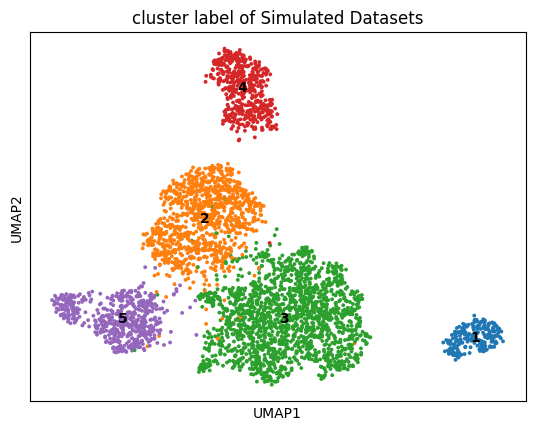

/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


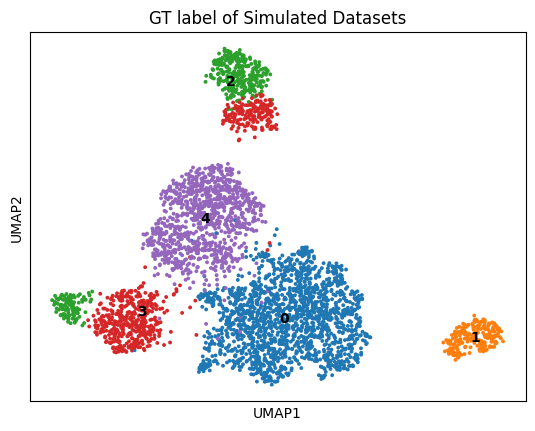

/home/hxl/anaconda/enter/envs/torch21_py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


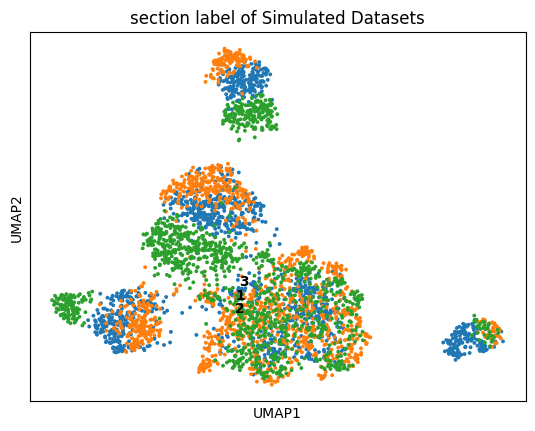

In [17]:
def read_list_from_file(path):
    list = []
    with open(path, 'r') as f:
        for line in f:
            num = int(line.strip())
            list.append(num)

    return list

feat_a1 = output['Smoe'][:1296]
feat_a2 = output['Smoe'][1296:2592]
feat_a3 = output['Smoe'][2592:3888]

features = np.vstack([feat_a1, feat_a2, feat_a3])

adata_combined = sc.AnnData(features)

    
from SME.utils import clustering
adata_combined.obsm['Smoe'] = features
tool = 'mclust'  # mclust, leiden, and louvain
clustering(adata_combined, key='Smoe', add_key='Clusters', n_clusters=5, method=tool,
            use_pca=True)
labels = adata_combined.obs['Clusters'].tolist()
adata_combined.obs['Clusters'] = np.array(labels).astype(str)
adata_combined.obs['Clusters'] = adata_combined.obs['Clusters'].astype('category')

## Save cluster label
# list = labels
# output_file = _output_path + key + '_cluster.txt'
# with open(output_file, 'w') as f:
#     for num in list:
#         f.write(f"{num}\n")

labels_a1 = read_list_from_file(base_path + 'Slice-1/GT.txt')
labels_a2 = read_list_from_file(base_path + 'Slice-2/GT.txt')
labels_a3 = read_list_from_file(base_path + 'Slice-3/GT.txt')

labels_a1 = np.array(labels_a1)
labels_a2 = np.array(labels_a2)
labels_a3 = np.array(labels_a3)

labels = np.concatenate([labels_a1, labels_a2, labels_a3])

# # save cluster
# Smoe_df = labels
# list = Smoe_df
# list = [label+1 for label in list]
# output_file = _output_path + key + '_1_2_3.txt'
# with open(output_file, 'w') as f:
#     for num in list:
#         f.write(f"{num}\n")

labels = np.array(labels)
adata_combined.obs['CLS_Label'] = labels.astype(str)  


## Umap 
sc.pp.neighbors(adata_combined, n_neighbors=20, use_rep='X')
sc.tl.umap(adata_combined)
sc.pl.umap(adata_combined, color='Clusters', title='cluster label of Simulated Datasets', legend_loc='on data')
sc.pl.umap(adata_combined, color='CLS_Label', title='GT label of Simulated Datasets', legend_loc='on data')


labels_a1 = np.repeat('1', 1296)
labels_a2 = np.repeat('2', 1296)
labels_a3 = np.repeat('3', 1296)

labels = np.concatenate([labels_a1, labels_a2, labels_a3])

adata_combined.obs['BC_Label'] = labels.astype(str)  

# 绘制 UMAP 图
sc.pl.umap(adata_combined, color='BC_Label', title='section label of Simulated Datasets', legend_loc='on data')


